# My solution for 1C competition
## Flow
### EDA and create features
```
A-1. Load CSV files
A-2. Data cleansing
A-3. Preprocessing
A-4. Summarize monthly sales
A-5. Merge master tables
A-6. Mean encoding & lag feature
A-7. Add more features
A-8. Store features
```

### Light GBM
```
B-1. Load features
B-2. Fitting 
B-3. Prediction
B-4. Evaluating results
B-5. Storing results
```

### NN(with Entity Embedding)
```
C-1. Load features
C-2. Build a neural network
C-3. Convert features for applying NN inputs 
C-4. Fitting 
C-5. Prediction
C-6. Evaluating results
C-7. Storing results
```

### Linear Regression
```
D-1. Load features
D-2. Fitting 
D-3. Prediction
D-4. Evaluating results
D-5. Storing results
```

### Ensemble with stacking
```
E-1. Load 1st results(LightGBM, NN, LR)
E-2. Create meta data for train and test 
E-3. Fitting 
E-4. Prediction
E-5. Storing final results
```


# A. EDA and create features

## A-1. Load CSV files

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

['items.csv', 'sample_submission.csv', 'test.csv', 'sales_train.csv', 'item_categories.csv', 'shops.csv']


In [2]:
items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
cats = pd.read_csv('../input/item_categories.csv')
train = pd.read_csv('../input/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('../input/test.csv').set_index('ID')

## A-2. Data cleansing
* Get rid of outer values
* I decided to use records which have item_cnt_day less than 5
* 99% against all records will be left

In [3]:
train.item_cnt_day.sort_values().apply(lambda x: '%.3f' % x).unique()

array(['-22.000', '-16.000', '-9.000', '-6.000', '-5.000', '-4.000',
       '-3.000', '-2.000', '-1.000', '1.000', '2.000', '3.000', '4.000',
       '5.000', '6.000', '7.000', '8.000', '9.000', '10.000', '11.000',
       '12.000', '13.000', '14.000', '15.000', '16.000', '17.000',
       '18.000', '19.000', '20.000', '21.000', '22.000', '23.000',
       '24.000', '25.000', '26.000', '27.000', '28.000', '29.000',
       '30.000', '31.000', '32.000', '33.000', '34.000', '35.000',
       '36.000', '37.000', '38.000', '39.000', '40.000', '41.000',
       '42.000', '43.000', '44.000', '45.000', '46.000', '47.000',
       '48.000', '49.000', '50.000', '51.000', '52.000', '53.000',
       '54.000', '55.000', '56.000', '57.000', '58.000', '59.000',
       '60.000', '61.000', '62.000', '63.000', '64.000', '65.000',
       '66.000', '67.000', '68.000', '69.000', '70.000', '71.000',
       '72.000', '73.000', '74.000', '75.000', '76.000', '77.000',
       '78.000', '79.000', '80.000', '81.000', '8

In [4]:
train.item_cnt_day.value_counts()

 1.0       2629372
 2.0        194201
 3.0         47350
 4.0         19685
 5.0         10474
-1.0          7252
 6.0          6338
 7.0          4057
 8.0          2903
 9.0          2177
 10.0         1820
 11.0         1263
 12.0         1083
 13.0          918
 14.0          716
 15.0          638
 16.0          544
 17.0          438
 18.0          391
 20.0          364
 19.0          347
 21.0          290
 22.0          242
 24.0          204
 23.0          198
 25.0          180
 26.0          176
 30.0          147
 28.0          131
 27.0          130
 31.0          123
 32.0          106
 29.0          102
 33.0           82
 34.0           81
-2.0            78
 35.0           69
 36.0           62
 37.0           61
 41.0           58
 40.0           58
 38.0           54
 39.0           52
 44.0           40
 46.0           39
 42.0           36
 43.0           34
 50.0           33
 45.0           31
 47.0           25
 49.0           25
 48.0           22
 52.0       

In [5]:
train[train.item_cnt_day < 6].count()[0] / train.shape[0]

0.9906633481490362

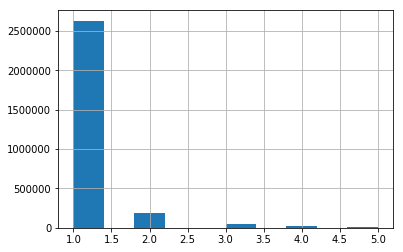

In [6]:
train[(train.item_cnt_day > 0) & (train.item_cnt_day < 6)].item_cnt_day.hist()

item_price: 
* The record which price is more than 6000 is filtered out 
* The record which has negative price is filtered out
* 99% against all records will be left


In [7]:
train.item_price.sort_values().apply(lambda x: '%.3f' % x).unique()

array(['-1.000', '0.070', '0.087', ..., '50999.000', '59200.000',
       '307980.000'], dtype=object)

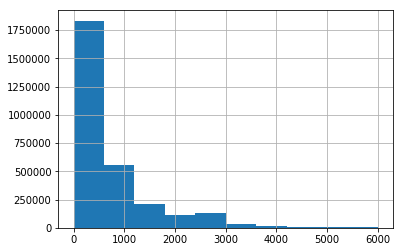

In [8]:
train[train.item_price < 6000].item_price.hist()

In [9]:
train[(train.item_price > 0) & (train.item_price < 6000)].count()[0] / train.shape[0]

0.9902195242330243

In [10]:
# narrow down
train = train[train.item_cnt_day < 6]
train = train[(train.item_price > 0) & (train.item_price < 6000)]

## A-3. Preprocessing
* shops: extract city
* categories: split into 2level
* items: threw out names

I refer a lot of ideas from the following kernel for data preparation.

link: https://www.kaggle.com/dlarionov/feature-engineering-xgboost



In [11]:
from sklearn.preprocessing import LabelEncoder

shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [12]:
# #items only in test
s = set(test.item_id) - (set(test.item_id) & set(train.item_id))
len(s)

407

In [13]:
# #items only in train
s = set(train.item_id) - (set(test.item_id) & set(train.item_id))
len(s)

16870

## A-4. Summarize monthly sales


* Some items weren't sold in train data. So in advance I created buckets by data_block_num, shop_id, item_id. 

In [14]:
from itertools import product

matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [15]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

In [16]:
# make the form of test as same as train
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)

## A-5. Merge master tables

* marge shops, categories,items into train matrix
* replace the type of some categorical columns with shorter type for memory saving

In [17]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

## A-6. Mean encoding & lag feature


In [18]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [19]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [20]:
def mean_encode_item_count_month(at, col_name, lags):
    global matrix
    group = matrix.groupby(at).agg({'item_cnt_month': ['mean']})
    group.columns = [ col_name ]
    group.reset_index(inplace=True)

    matrix = pd.merge(matrix, group, on=at, how='left')
    matrix[col_name] = matrix[col_name].astype(np.float16)
    matrix = lag_feature(matrix, lags, col_name)
    matrix.drop([col_name], axis=1, inplace=True)

In [21]:
mean_encode_item_count_month(['date_block_num'], 'date_avg_item_cnt', [1])
mean_encode_item_count_month(['date_block_num', 'item_id'], 'date_item_avg_item_cnt', [1,2,3,6,12])
mean_encode_item_count_month(['date_block_num', 'shop_id'], 'date_shop_avg_item_cnt', [1,2,3,6,12])
mean_encode_item_count_month(['date_block_num', 'item_category_id'], 'date_cat_avg_item_cnt', [1])
mean_encode_item_count_month(['date_block_num', 'shop_id', 'item_category_id'], 'date_shop_cat_avg_item_cnt', [1])
mean_encode_item_count_month(['date_block_num', 'shop_id', 'type_code'], 'date_shop_type_avg_item_cnt', [1])
mean_encode_item_count_month(['date_block_num', 'shop_id', 'subtype_code'], 'date_shop_subtype_avg_item_cnt', [1])
mean_encode_item_count_month(['date_block_num', 'city_code'], 'date_city_avg_item_cnt', [1])
mean_encode_item_count_month(['date_block_num', 'item_id', 'city_code'], 'date_item_city_avg_item_cnt', [1])
mean_encode_item_count_month(['date_block_num', 'type_code'], 'date_type_avg_item_cnt', [1])
mean_encode_item_count_month(['date_block_num', 'subtype_code'], 'date_subtype_avg_item_cnt', [1])

## A-7. Add more features

In [22]:
matrix['month'] = matrix['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

[Idea (Not yet tried)]

Use the weights of Entity embedding in NN for LightGBM, LR.

## A-8. Store features

In [23]:
matrix = matrix[matrix.date_block_num > 11]

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [24]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'month', 'days'],
      dtype='o

In [25]:
matrix.to_pickle('data.pkl')

del matrix
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# B. LightGBM

## B-1. Load features

In [26]:
data = pd.read_pickle('data.pkl')

In [27]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'month',
    'days'
]]

## B-2. Fitting

In [28]:
# divide into train, validation, test
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

del data
gc.collect()

14

In [29]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'rmse',
        'metric': {'rmse'},
        'num_class': 1,
        'learning_rate': 0.1,
        'num_leaves': 128,
        'min_data_in_leaf': 1,
        'num_iteration': 100,
        'verbose': 0
}

gbm = lgb.train(params,
            lgb_train,
            num_boost_round=50,
            valid_sets=lgb_eval,
            early_stopping_rounds=5)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 0.96381
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.9356
[3]	valid_0's rmse: 0.911584
[4]	valid_0's rmse: 0.891918
[5]	valid_0's rmse: 0.87531
[6]	valid_0's rmse: 0.861229
[7]	valid_0's rmse: 0.849046
[8]	valid_0's rmse: 0.839253
[9]	valid_0's rmse: 0.831504
[10]	valid_0's rmse: 0.823978
[11]	valid_0's rmse: 0.819119
[12]	valid_0's rmse: 0.81357
[13]	valid_0's rmse: 0.810114
[14]	valid_0's rmse: 0.807207
[15]	valid_0's rmse: 0.805844
[16]	valid_0's rmse: 0.804106
[17]	valid_0's rmse: 0.802256
[18]	valid_0's rmse: 0.801831
[19]	valid_0's rmse: 0.801672
[20]	valid_0's rmse: 0.801676
[21]	valid_0's rmse: 0.79952
[22]	valid_0's rmse: 0.798984
[23]	valid_0's rmse: 0.798064
[24]	valid_0's rmse: 0.796872
[25]	valid_0's rmse: 0.796304
[26]	valid_0's rmse: 0.795671
[27]	valid_0's rmse: 0.796941
[28]	valid_0's rmse: 0.796646
[29]	valid_0's rmse: 0.797304
[30]	valid_0's rmse: 0.79715
[31]	valid_0's rmse: 0.796708
Early stopping, best iter

## B-3. Prediction

In [30]:
Y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration).clip(0, 20)
Y_test = gbm.predict(X_test, num_iteration=gbm.best_iteration).clip(0, 20)

## B-4. Evaluating results

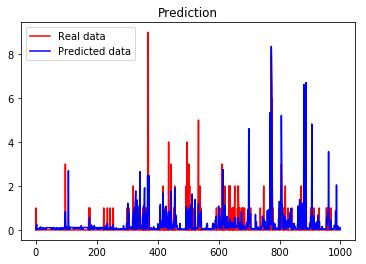

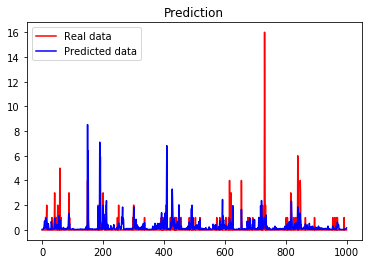

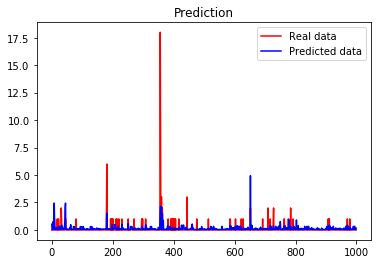

In [31]:
# predict vs correct
import matplotlib.pyplot as plt

def draw_vs(s, e):    
    r_start = s
    r_end = e
    plt.plot(Y_valid[r_start:r_end].reset_index()['item_cnt_month'], color = 'red', label = 'Real data')
    plt.plot(Y_pred[r_start:r_end], color = 'blue', label = 'Predicted data')
    plt.title('Prediction')
    plt.legend()
    plt.show()
    
draw_vs(0, 1000)
draw_vs(1000, 2000)
draw_vs(2000, 3000)

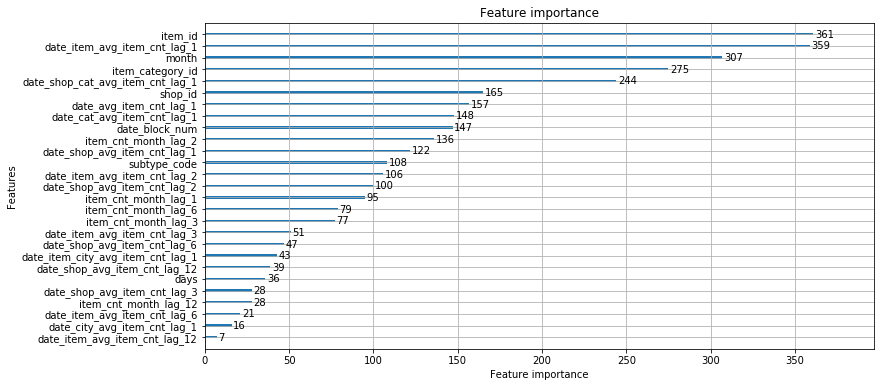

In [32]:
# check importance
import matplotlib.pyplot as plt

lgb.plot_importance(gbm, figsize=(12, 6))
plt.show()

## B-5. Storing results

In [33]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
import pickle
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

del X_train, Y_train, X_valid, Y_valid, X_test, submission
gc.collect()

13572

# C. NN+Entity Embedding

## C-1. Load features

In [34]:
data = pd.read_pickle('data.pkl')

In [35]:
embed_cols = ['shop_id', 'item_id', 'city_code', 'item_category_id', 'type_code', 'subtype_code']

In [36]:
# float16 -> float32
for col in [c for c in data.columns if (not c in embed_cols)]:
    data[col] = data[col].astype(np.float32)

## C-2. Build a neural network

* Used Embedding layer for categorical variables
* If added the embedding layer of input_item_id, the training will diverge. Too big?



In [37]:
def build_embedding_network():
    
    inputs = []
    embeddings = []
    
    input_shop_id = Input(shape=(1,))
    embedding = Embedding(55 + 1, 5, input_length=1, embeddings_initializer='random_uniform')(input_shop_id)
    embedding = Flatten()(embedding)
    inputs.append(input_shop_id)
    embeddings.append(embedding)
    
    input_item_id = Input(shape=(1,))
#     embedding = Embedding(17270, 5, input_length=1, embeddings_initializer=uniform())(input_item_id)
#     embedding = Flatten()(embedding)
    inputs.append(input_item_id)
#     embeddings.append(embedding)

    input_city_code = Input(shape=(1,))
    embedding = Embedding(31+1, 5, input_length=1, embeddings_initializer='random_uniform')(input_city_code)
    embedding = Flatten()(embedding)
    inputs.append(input_city_code)
    embeddings.append(embedding)
    
    input_item_category_id = Input(shape=(1,))
#     embedding = Embedding(80+1, 5, input_length=1)(input_item_category_id)
#     embedding = Reshape(target_shape=(5,))(embedding)
    inputs.append(input_item_category_id)
#     embeddings.append(embedding)
    
    input_type_code = Input(shape=(1,))
    embedding = Embedding(20+1, 5, input_length=1, embeddings_initializer='random_uniform')(input_type_code)
    embedding = Flatten()(embedding)
    inputs.append(input_type_code)
    embeddings.append(embedding)
    
    input_subtype_code = Input(shape=(1,))
    embedding = Embedding(63+1, 5, input_length=1, embeddings_initializer='random_uniform')(input_subtype_code)
    embedding = Flatten()(embedding)
    inputs.append(input_subtype_code)
    embeddings.append(embedding)
    
    input_non_categorical = Input(shape=(27,))
    inputs.append(input_non_categorical)
    embeddings.append(input_non_categorical)
    
    x = Concatenate()(embeddings)
    x = Dense(128, activation='relu', kernel_initializer='normal')(x)
    x = Dropout(.35)(x)
    x = Dense(128, activation='relu', kernel_initializer='normal')(x)
    x = Dropout(.15)(x)
    x = Dense(64, activation='relu', kernel_initializer='normal')(x)
    x = Dropout(.15)(x)
    output = Dense(1, kernel_initializer='normal', activation='linear')(x)
    
    model = Model(inputs, output)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    
    return model

## C-3. Convert features for applying NN inputs

In [38]:
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    # for categorical variables
    for c in embed_cols:
        input_list_train.append(X_train[c].values)
        input_list_val.append(X_val[c].values)
        input_list_test.append(X_test[c].values)
     
    # the rest of the variables
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    
    train_data = X_train[other_cols].values
    val_data = X_val[other_cols].values
    test_data = X_test[other_cols].values
    
    # scaling non-categorical variables
    mean = train_data.mean(axis=0)
    std = train_data.std(axis=0)
    
    train_data = (train_data - mean) / std
    val_data = (val_data - mean) / std
    test_data = (test_data - mean) / std
    
    input_list_train.append(train_data)
    input_list_val.append(val_data)
    input_list_test.append(test_data)
    
    return input_list_train, input_list_val, input_list_test    

## C-4. Fitting 

In [39]:
# divide into train, validation, test
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

del data
gc.collect()

7

In [40]:
#train
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout, Flatten
from keras.layers.embeddings import Embedding

n_epochs = 10

#preprocessing
proc_X_train, proc_X_val, proc_X_test = preproc(X_train, X_valid, X_test)

NN = build_embedding_network()
NN.summary()
history = NN.fit(proc_X_train, Y_train.values, epochs=n_epochs, batch_size=4096, verbose=2, validation_data=(proc_X_val, Y_valid.values))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer) 

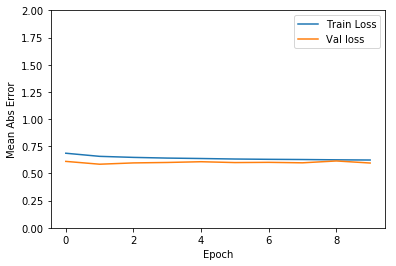

In [41]:
import matplotlib.pyplot as plt
 

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_squared_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_squared_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0,2])

plot_history(history)

## C-5. Prediction

In [42]:
#predict
Y_pred = NN.predict(proc_X_val).clip(0, 20)
Y_test = NN.predict(proc_X_test).clip(0, 20)

## C-6. Evaluating results

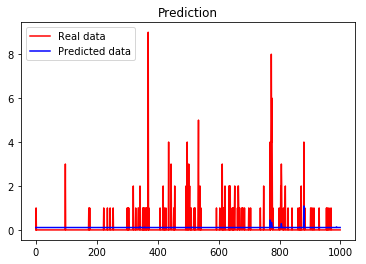

In [43]:
# evaluation
r_start = 0
r_end = 1000
plt.plot(Y_valid[r_start:r_end].reset_index()['item_cnt_month'], color = 'red', label = 'Real data')
plt.plot(Y_pred.flatten()[r_start:r_end], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

## C-7. Storing results

In [44]:
# submission

test = pd.read_csv('../input/test.csv').set_index('ID')

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test.flatten()
})
submission.to_csv('nn_submission.csv', index=False)

# save predictions for an ensemble
import pickle
pickle.dump(Y_pred, open('nn_train.pickle', 'wb'))
pickle.dump(Y_test.flatten(), open('nn_test.pickle', 'wb'))

del X_train, Y_train, X_valid, Y_valid, X_test, submission
gc.collect()

5037

# D. Linear regression

## D-1. Load features

In [45]:
data = pd.read_pickle('data.pkl')

In [46]:
# use only non-categorical items
data.drop(['item_id', 'item_category_id', 'shop_id', 'city_code', 'type_code', 'subtype_code'], axis=1, inplace=True)

# float16 -> float32
for col in data.columns:
    data[col] = data[col].astype(np.float32)

## D-2. Fitting 

In [47]:
# divide into train, validation, test
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

del data
gc.collect()

14

In [48]:
X_train.sample(10)

,date_block_num,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,month,days
6622806,18.0,0.0,0.0,0.0,0.0,0.0,0.268799,0.061218,0.102051,0.224487,0.239136,1.608398,0.147461,0.132812,0.119995,0.139771,0.149292,0.233032,0.191895,0.135986,0.191895,0.147461,0.0,0.182983,0.233032,6.0,31.0
5002806,13.0,0.0,0.0,0.0,0.0,0.0,0.307861,0.065247,0.173950,0.244385,0.444336,0.173950,0.248413,0.337402,0.232910,0.243652,0.221802,0.099060,0.000000,0.091980,0.000000,0.248413,0.0,0.157959,0.099060,1.0,28.0
5560480,15.0,0.0,0.0,1.0,2.0,3.0,0.293701,0.250000,0.260986,0.826172,0.826172,0.717285,0.286865,0.293457,0.327881,0.272949,0.276611,0.307861,0.266602,0.558105,0.314697,0.286865,0.0,0.692383,0.279785,3.0,30.0
4467147,12.0,0.0,0.0,0.0,0.0,0.0,0.404053,0.043488,0.088867,0.065247,0.413086,0.000000,0.129150,0.111816,0.095276,0.079956,0.000000,0.232544,0.063782,0.074280,0.059296,0.129150,0.0,0.269287,0.233765,0.0,31.0
5216438,14.0,0.0,0.0,0.0,0.0,0.0,0.300537,0.130493,0.086975,0.130493,0.222168,0.000000,0.193237,0.181152,0.262939,0.164429,0.000000,0.151123,0.113159,0.138550,0.122803,0.218872,0.0,0.202881,0.152710,2.0,31.0
4538490,12.0,0.0,0.0,0.0,0.0,0.0,0.404053,0.152222,0.133301,0.260986,0.108704,0.000000,0.310059,0.216064,0.189087,0.317871,0.000000,0.062042,0.000000,0.267822,0.000000,0.310059,0.0,0.239014,0.062042,0.0,31.0
4866892,13.0,0.0,0.0,0.0,1.0,0.0,0.307861,0.695801,0.478271,0.333252,0.888672,0.717285,0.161255,0.203003,0.170532,0.217163,0.206665,0.256836,0.063232,0.077881,0.063232,0.141968,0.0,0.230225,0.256836,1.0,28.0
9969041,30.0,0.0,0.0,1.0,1.0,0.0,0.260010,0.093018,0.181763,0.152222,0.600098,1.099609,0.165283,0.136108,0.137939,0.183228,0.144531,0.582031,0.134888,0.115356,0.134888,0.165283,0.0,0.270752,0.582031,6.0,31.0
6442791,17.0,0.0,2.0,4.0,2.0,0.0,0.257812,1.775391,2.164062,2.583984,2.238281,0.000000,0.163330,0.163208,0.189453,0.263184,0.000000,0.245972,0.181763,0.117676,0.181763,0.163330,0.0,0.264404,0.245972,5.0,30.0
10286985,31.0,0.0,0.0,0.0,1.0,1.0,0.257812,0.558105,0.395264,0.272705,0.744629,0.470703,0.582520,0.582031,0.562500,0.579590,0.503906,0.227539,0.309082,0.622559,0.309082,0.582520,0.0,0.297852,0.227539,7.0,31.0


In [49]:
#train
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, Y_train)
score = model.score(X_valid, Y_valid)
print(score)

0.34973202686667226


## D-3. Prediction

In [50]:
#predict
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

## D-4. Evaluating results

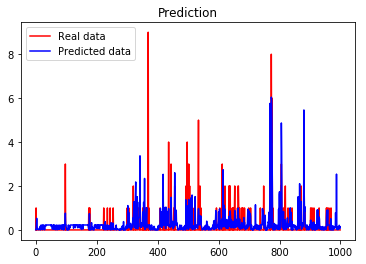

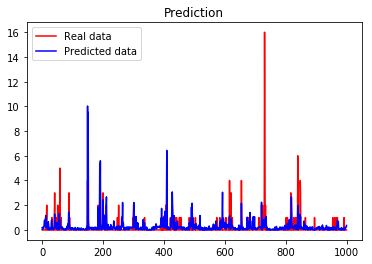

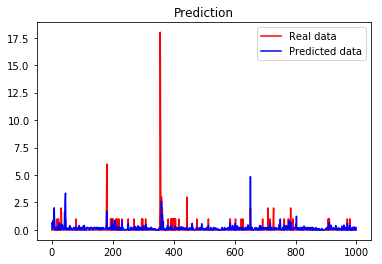

In [51]:
import matplotlib.pyplot as plt

def drow_vs(s, e):    
    r_start = s
    r_end = e
    plt.plot(Y_valid[r_start:r_end].reset_index()['item_cnt_month'], color = 'red', label = 'Real data')
    plt.plot(Y_pred[r_start:r_end], color = 'blue', label = 'Predicted data')
    plt.title('Prediction')
    plt.legend()
    plt.show()
    
drow_vs(0, 1000)
drow_vs(1000, 2000)
drow_vs(2000, 3000)

## D-5. Storing results

In [52]:
# submission

test = pd.read_csv('../input/test.csv').set_index('ID')

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('lr_submission.csv', index=False)

# save predictions for an ensemble
import pickle
pickle.dump(Y_pred, open('lr_train.pickle', 'wb'))
pickle.dump(Y_test, open('lr_test.pickle', 'wb'))

del X_train, Y_train, X_valid, Y_valid, X_test, submission
gc.collect()

7793

# E. Stacking

## E-1. Load 1st results(LightGBM, NN, LR)

In [53]:
lr_train = pd.read_pickle('lr_train.pickle')
lr_test = pd.read_pickle('lr_test.pickle')

nn_train = pd.read_pickle('nn_train.pickle')
nn_test = pd.read_pickle('nn_test.pickle')

xgb_train = pd.read_pickle('xgb_train.pickle')
xgb_test = pd.read_pickle('xgb_test.pickle')

## E-2. Create metadata for train and test 

In [54]:
X_train_ens = pd.DataFrame({'lr': lr_train, 'nn': nn_train.flatten(), 'xgb': xgb_train})

In [55]:
X_test_ens = pd.DataFrame({'lr': lr_test, 'nn': nn_test, 'xgb': xgb_test})

In [56]:
X_test_ens

,lr,nn,xgb
0,0.458031,0.510839,0.640308
1,0.236922,0.369449,0.362986
2,1.077911,1.073625,0.960344
3,0.231150,0.642797,0.413052
4,0.236922,2.815936,1.011416
5,0.612466,0.669898,0.586906
6,1.011539,0.663408,1.077395
7,0.131100,0.152737,0.160751
8,0.909444,0.782032,0.877605
9,0.740180,1.008883,1.089585


In [57]:
data = pd.read_pickle('data.pkl')
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

## E-3. Fitting 

In [58]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train_ens, Y_valid)
score = model.score(X_train_ens, Y_valid)
print(score)

0.4144780357845195


## E-4. Prediction

In [59]:
Y_test = model.predict(X_test_ens).clip(0, 20)

In [60]:
test = pd.read_csv('../input/test.csv').set_index('ID')

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('stacking_submission.csv', index=False)